In [23]:
# STEM GPT: A chatbot that helps us analyze biological TEM data with auto segmentation.

In [24]:
# Utility: quick benchmark for Cellpose quick-mode (downsized inference timings)
import time

def quick_cellpose_benchmark(name=None, feature='mitochondria', scales=(0.5, 0.35, 0.25), repeats=1):
    if not globals().get('HAVE_CELLPOSE'):
        print('Cellpose not available in this kernel. Install it in the kernel environment and re-run.')
        return
    if name is None:
        files = toolbox.list_files()
        if not files:
            print('No .tif files found to benchmark.')
            return
        name = files[0]
    print('Benchmarking', name)
    results = []
    for scale in scales:
        times = []
        counts = []
        for r in range(repeats):
            t0 = time.time()
            res = toolbox.segment(min_size=20, feature=feature, method='cellpose', quick=True, q_scale=scale, skip_props=True, do_resize_back=False, overlay_scale=scale)
            t1 = time.time()
            times.append(t1 - t0)
            counts.append(res['count'])
        results.append({'scale': scale, 'time_mean': sum(times)/len(times), 'time_min': min(times), 'time_max': max(times), 'count_mean': sum(counts)/len(counts)})
        print(f"scale={scale}: time_mean={results[-1]['time_mean']:.2f}s (min={results[-1]['time_min']:.2f}, max={results[-1]['time_max']:.2f}) count_mean={results[-1]['count_mean']:.1f}")
    return results

# Example usage (uncomment to run):
# quick_cellpose_benchmark(scales=(0.5,0.35,0.25), repeats=2)

# Environment & data loading

This section installs required packages (if missing), lists `.tif` images in `data/`, and provides an interactive selector and a programmatic query option to load and inspect an image.

In [ ]:
# Install and import required packages (installs missing ones automatically)
import sys, subprocess

def ensure_import(pkg_name, import_name=None):
    import importlib
    try:
        importlib.import_module(import_name or pkg_name)
    except ImportError:
        print(f"Installing {pkg_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg_name])

for pkg, name in [("tifffile", "tifffile"), ("scikit-image", "skimage"), ("ipywidgets", "ipywidgets"), ("matplotlib", "matplotlib"), ("numpy", "numpy"), ("pillow", "PIL"), ("pandas", "pandas"), ("scipy", "scipy")]:
    ensure_import(pkg, name)

# Imports
from pathlib import Path
import os
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

plt.rcParams['figure.dpi'] = 100

In [26]:
# Chat UI (uses consolidated `process_command` and `state` helpers)
from ipywidgets import Text, Button, HBox, Output

input_box = Text(placeholder='Type commands like: list files | show <name> | stats | segment mitochondria', description='Query:')
send_btn = Button(description='Send')
chat_out = Output(layout={'border': '1px solid #ddd'})


def append(role, text):
    with chat_out:
        print(f"{role}: {text}")


def _on_send(b):
    text = input_box.value.strip()
    if not text:
        return
    append('User', text)
    resp = process_command(text, state, out=chat_out)
    append('Bot', resp)
    input_box.value = ''

send_btn.on_click(_on_send)

# Show the widgets
display(HBox([input_box, send_btn]), chat_out)
append('System', "Tip: try 'list files', 'show <name>', 'stats', 'segment mitochondria' or 'help'.")

Output(layout=Layout(border_bottom='1px solid #ddd', border_left='1px solid #ddd', border_right='1px solid #dd…

## Refactor: Consolidated utilities and command processor

This cell consolidates image I/O, display, statistics, segmentation, and the command parser into a single, reusable utilities module.

Run this cell before running the chat UI cell so the helpers are available to the UI.

In [27]:
# Ensure Pillow is installed for image serialization
import sys, subprocess
# Pillow import consolidated above; just import Image here
from PIL import Image  # pillow ensured in consolidated imports cell

In [28]:
# Ensure pandas is installed (needed for metric extraction)
# pandas ensured in consolidated imports; just import here
import pandas as pd
import sys, subprocess

# Check for Cellpose availability but do NOT try to install it automatically
# (automatic install can fail on some platforms; provide manual instructions instead)
HAVE_CELLPOSE = False
try:
    from cellpose import models  # type: ignore
    HAVE_CELLPOSE = True
except Exception:
    HAVE_CELLPOSE = False
    print("Cellpose is not installed in this environment.")
    print("Recommended installation options (PowerShell):")
    print(" - Conda (recommended):\n   conda create -n cellpose python=3.10 -y; conda activate cellpose; conda install -c conda-forge pytorch cpuonly -y; pip install cellpose")
    print(" - Pip (if compatible wheels exist):\n   python -m pip install torch --index-url https://download.pytorch.org/whl/cpu; python -m pip install cellpose")
    print("If you don't want to install Cellpose, the notebook will use the classical scikit-image segmentation as a fallback.")

In [29]:
# Utilities: consolidated helpers + TEMToolbox
from pathlib import Path
import os
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from difflib import get_close_matches
from skimage import filters, morphology, measure
from IPython.display import display
from PIL import Image
import io, base64

plt.rcParams['figure.dpi'] = 100

DATA_DIR = Path("data")

# --- low-level helpers (unchanged behavior) ---

def list_tif_files():
    return sorted(DATA_DIR.glob("*.tif"))


def choose_by_query(query, files=None):
    if not query:
        return None
    files = files or list_tif_files()
    for p in files:
        if Path(query).name == p.name or query in p.name:
            return p
    names = [p.name for p in files]
    matches = get_close_matches(query, names, n=1, cutoff=0.4)
    if matches:
        m = matches[0]
        return Path(m) if Path(m).is_absolute() else DATA_DIR / m
    return None


def load_image(path):
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(path)
    img = tifffile.imread(path)
    if img.ndim == 3 and img.shape[0] > 1 and img.shape[1] == img.shape[2]:
        img = img[0]
    return np.squeeze(img)


def image_to_png_bytes(img_array, cmap='gray'):
    """Return PNG bytes for a numpy image (2D or 3D)."""
    arr = np.asarray(img_array)
    if arr.ndim == 2:
        # convert to 8-bit for display
        vmin, vmax = arr.min(), arr.max()
        if vmax > vmin:
            norm = (arr - vmin) / (vmax - vmin)
        else:
            norm = np.zeros_like(arr, dtype=np.float32)
        rgb = (plt.cm.gray(norm)[:, :, :3] * 255).astype(np.uint8)
    elif arr.ndim == 3 and arr.shape[2] in (3,4):
        rgb = arr.astype(np.uint8)
    else:
        # fallback: show first channel
        rgb = np.squeeze(arr)
        if rgb.ndim == 2:
            vmin, vmax = rgb.min(), rgb.max()
            if vmax > vmin:
                norm = (rgb - vmin) / (vmax - vmin)
            else:
                norm = np.zeros_like(rgb, dtype=np.float32)
            rgb = (plt.cm.gray(norm)[:, :, :3] * 255).astype(np.uint8)
        else:
            rgb = (rgb * 255).astype(np.uint8)
    im = Image.fromarray(rgb)
    buf = io.BytesIO()
    im.save(buf, format='PNG')
    return buf.getvalue()


def overlay_mask_on_image(img_array, mask_bool, color=(255,0,0), alpha=0.35):
    """Return PNG bytes of overlay image (RGB) where mask is shown with given color and alpha."""
    img = np.asarray(img_array)
    # create background RGB
    if img.ndim == 2:
        vmin, vmax = img.min(), img.max()
        if vmax > vmin:
            norm = (img - vmin) / (vmax - vmin)
        else:
            norm = np.zeros_like(img, dtype=np.float32)
        bg = (plt.cm.gray(norm)[:, :, :3] * 255).astype(np.uint8)
    elif img.ndim == 3 and img.shape[2] in (3,4):
        bg = img.astype(np.uint8)[:, :, :3]
    else:
        bg = np.tile((img / np.max(img) * 255).astype(np.uint8)[..., None], (1,1,3))
    fg = bg.copy()
    mask = np.asarray(mask_bool).astype(bool)
    fg[mask] = (np.array(color, dtype=np.uint8) * 1.0).astype(np.uint8)
    # blend
    out = (bg * (1-alpha) + fg * alpha).astype(np.uint8)
    im = Image.fromarray(out)
    buf = io.BytesIO()
    im.save(buf, format='PNG')
    return buf.getvalue()


def image_bytes_to_base64_str(b):
    return base64.b64encode(b).decode('ascii')


# --- metric & segmentation helpers (expanded) ---


def image_stats(img, out=None):
    arr = np.asarray(img)
    summary = f"dtype:{arr.dtype} shape:{arr.shape} min:{arr.min()} max:{arr.max()} mean:{float(arr.mean()):.3f}"
    if out is None:
        print(summary)
        plt.figure(figsize=(5,2)); plt.hist(arr.ravel(), bins=256); plt.title('Pixel intensity histogram'); plt.show()
    else:
        with out:
            print(summary)
            plt.figure(figsize=(5,2)); plt.hist(arr.ravel(), bins=256); plt.title('Pixel intensity histogram'); plt.show()
    return summary


def segment_mitochondria(img, min_size=50):
    imgf = img.astype(np.float32)
    try:
        thresh = filters.threshold_otsu(imgf)
    except Exception:
        thresh = np.percentile(imgf, 50)
    bw = imgf > thresh
    bw = morphology.remove_small_objects(bw.astype(bool), min_size=min_size)
    bw = morphology.binary_closing(bw, morphology.disk(2))
    labels = measure.label(bw)
    props = measure.regionprops(labels)
    areas = [p.area for p in props]
    return {'mask': bw, 'labels': labels, 'count': len(props), 'areas': areas, 'thresh': float(thresh)}


def segment_nuclei(img, min_size=500):
    """Segment nuclei by smoothing + thresholding + hole-filling.
    Returns the same dict structure as other segment_* helpers."""
    imgf = img.astype(np.float32)
    # smooth to reduce small texture
    img_s = filters.gaussian(imgf, sigma=2)
    try:
        thresh = filters.threshold_otsu(img_s)
    except Exception:
        thresh = np.percentile(img_s, 50)
    bw = img_s > thresh
    # remove small noisy objects and close gaps
    bw = morphology.remove_small_objects(bw.astype(bool), min_size=min_size)
    bw = morphology.binary_closing(bw, morphology.disk(5))
    # remove small holes (area threshold relative to min_size)
    bw = morphology.remove_small_holes(bw, area_threshold=max(64, min_size*2))
    labels = measure.label(bw)
    props = measure.regionprops(labels)
    areas = [p.area for p in props]
    return {'mask': bw, 'labels': labels, 'count': len(props), 'areas': areas, 'thresh': float(thresh)}


def segment_membrane(img, sigma=1.0, edge_thresh=None):
    """Detect membrane-like thin structures using an edge detector + dilation.
    This produces a mask of membrane pixels rather than compact objects.
    """
    imgf = img.astype(np.float32)
    # compute edge strength
    edge = filters.sobel(imgf)
    if edge_thresh is None:
        try:
            edge_thresh = filters.threshold_otsu(edge)
        except Exception:
            edge_thresh = np.percentile(edge, 75)
    bw = edge > edge_thresh
    # make membranes thicker for visualization and measurements
    bw = morphology.binary_dilation(bw, morphology.disk(2))
    bw = morphology.remove_small_objects(bw.astype(bool), min_size=20)
    labels = measure.label(bw)
    props = measure.regionprops(labels)
    areas = [p.area for p in props]
    return {'mask': bw, 'labels': labels, 'count': len(props), 'areas': areas, 'edge_thresh': float(edge_thresh)}


def segment_with_cellpose(img, min_size=50, diameter=None, model_type=None, channels=[0,0], use_gpu=False, quick=True, q_scale=0.25, skip_props=True, augment=False, do_resize_back=False, **kwargs):
    """Segment with Cellpose and postprocess with skimage morph operations.
    Quick mode downsamples the image before inference and rescales the mask back to
    the original resolution to provide a fast "quick and dirty" test.

        Parameters:
            quick (bool, default True): If True, downsample the image by q_scale before running Cellpose (fast mode).
            q_scale (float, default 0.25): Downsample scale factor (0.25 recommended for very fast tests).
            skip_props (bool, default True): If True, skip computing regionprops/areas (faster).
    Returns same dict structure as other segment_* helpers.
    """
    try:
        from cellpose import models
    except Exception:
        raise RuntimeError("Cellpose is not available. Install it with `pip install cellpose` or run the setup cell in the notebook.")

    # prepare image (ensure 2D grayscale float32)
    img_in = np.asarray(img)
    if img_in.ndim == 3 and img_in.shape[2] in (3,4):
        img_proc = img_in.mean(axis=2).astype(np.float32)
    else:
        img_proc = img_in.astype(np.float32)

    orig_shape = img_proc.shape[:2]

    # Optionally downsample for a quick test
    did_down = False
    if quick and q_scale is not None and q_scale > 0 and q_scale < 0.99:
        try:
            from skimage.transform import rescale, resize
            img_small = rescale(img_proc, q_scale, anti_aliasing=True, preserve_range=True).astype(np.float32)
            did_down = True
        except Exception:
            # fallback to simple subsampling
            img_small = img_proc[::max(1, int(1/q_scale)), ::max(1, int(1/q_scale))]
            did_down = True
    else:
        img_small = img_proc

    # cellpose API: use CellposeModel in newer versions
    model_type = model_type or 'cyto'
    # pretrained_model param accepts names like 'cyto' or 'nuclei'
    model = models.CellposeModel(gpu=use_gpu, pretrained_model=model_type, model_type=model_type)

    # run inference on the (possibly) downsampled image
    masks, flows, styles = model.eval(img_small, diameter=diameter, channels=channels)
    mask = masks.astype(bool)

    # if we downsampled, optionally resize mask back to original image size (nearest-neighbor)
    mask_scale = 1.0
    if did_down and mask.shape[:2] != orig_shape:
        mask_scale = float(orig_shape[0]) / float(mask.shape[0])
        if do_resize_back:
            try:
                from skimage.transform import resize
                mask = resize(mask.astype(np.uint8), orig_shape, order=0, preserve_range=True).astype(bool)
            except Exception:
                # fallback: simple nearest-neighbor upsampling using numpy (fast but crude)
                ry = int(round(orig_shape[0] / mask.shape[0]))
                rx = int(round(orig_shape[1] / mask.shape[1]))
                mask = np.repeat(np.repeat(mask, ry, axis=0), rx, axis=1)[:orig_shape[0], :orig_shape[1]]

    # attach info about quick-run scaling so callers can produce small overlays if desired
    meta_quick = {'did_down': did_down, 'mask_scale': mask_scale, 'skip_props': bool(skip_props), 'quick': bool(quick)}

    # postprocess similarly to skimage pipeline
    mask = morphology.remove_small_objects(mask, min_size=min_size)
    labels = measure.label(mask)

    if skip_props or quick:
        # fast path: avoid computing regionprops (areas) which can be slow
        count = int(labels.max()) if labels is not None else 0
        areas = []
    else:
        props = measure.regionprops(labels)
        areas = [p.area for p in props]
        count = len(props)

    out = {'mask': mask, 'labels': labels, 'count': count, 'areas': areas, 'method': 'cellpose', 'model_type': model_type, 'diameter': float(diameter) if diameter is not None else None}
    out.update(meta_quick)
    return out


def segment_feature(img, feature='mitochondria', method='skimage', **kwargs):
    """Dispatch segmentation to either the classical skimage pipeline (default) or a DL model.
    method: 'skimage' or 'cellpose'
    Additional kwargs are forwarded to the underlying routine.
    """
    feature = feature.lower()
    if method == 'cellpose':
        # pick a sensible default model_type for the feature when not provided
        model_type = kwargs.pop('model_type', None)
        if model_type is None:
            if feature in ('nucleus', 'nuclei'):
                model_type = 'nuclei'
            else:
                model_type = 'cyto'
        # default to quick, downsampled Cellpose runs for fast smoke tests unless overridden
        kwargs.setdefault('quick', True)
        kwargs.setdefault('q_scale', 0.25)
        kwargs.setdefault('skip_props', True)
        kwargs.setdefault('do_resize_back', False)
        return segment_with_cellpose(img, model_type=model_type, **kwargs)

    # fallback to classical skimage-based routines
    if feature in ('mito', 'mitochondria'):
        return segment_mitochondria(img, **kwargs)
    if feature in ('nucleus', 'nuclei'):
        return segment_nuclei(img, **kwargs)
    if feature in ('membrane', 'cell membrane', 'membranes'):
        return segment_membrane(img, **kwargs)
    raise ValueError(f"Unknown feature to segment: {feature}")


def extract_metrics(labels, img):
    """Extract shape and intensity metrics from labeled segmentation as a pandas DataFrame."""
    props = measure.regionprops(labels, intensity_image=img)
    rows = []
    for prop in props:
        r = {
            'label': int(prop.label),
            'area': int(prop.area),
            'perimeter': float(prop.perimeter) if hasattr(prop, 'perimeter') else np.nan,
            'eccentricity': float(prop.eccentricity),
            'solidity': float(prop.solidity),
            'mean_intensity': float(prop.mean_intensity) if hasattr(prop, 'mean_intensity') else np.nan,
            'centroid_row': float(prop.centroid[0]),
            'centroid_col': float(prop.centroid[1]),
            'bbox_minr': int(prop.bbox[0]),
            'bbox_minc': int(prop.bbox[1]),
            'bbox_maxr': int(prop.bbox[2]),
            'bbox_maxc': int(prop.bbox[3])
        }
        rows.append(r)
    df = pd.DataFrame(rows)
    # keep pixel-area units; user can convert to physical units if pixel_size known
    return df


def save_metrics_to_csv(df, filename='metrics.csv'):
    df.to_csv(filename, index=False)
    return filename


# --- NEW: summary & plotting helpers for metrics (unchanged) ---

def summarize_metrics_df(df):
    if df is None or df.empty:
        return {'count':0,'area_mean':np.nan,'area_median':np.nan,'area_std':np.nan}
    return {'count': len(df), 'area_mean': float(df['area'].mean()), 'area_median': float(df['area'].median()), 'area_std': float(df['area'].std())}


def plot_metric_histogram(df1, df2=None, labels=('A','B'), metric='area', bins=30):
    plt.figure(figsize=(8,4))
    ax1 = plt.subplot(1,2,1)
    if df2 is None:
        ax1.hist(df1[metric].dropna(), bins=bins, alpha=0.7)
        ax1.set_title(f"{labels[0]} {metric} histogram")
    else:
        ax1.hist(df1[metric].dropna(), bins=bins, alpha=0.6, label=labels[0])
        ax1.hist(df2[metric].dropna(), bins=bins, alpha=0.6, label=labels[1])
        ax1.legend()
        ax1.set_title(f"{metric} histogram")

    ax2 = plt.subplot(1,2,2)
    if df2 is None:
        ax2.boxplot(df1[metric].dropna())
        ax2.set_title(f"{labels[0]} {metric} boxplot")
    else:
        data = [df1[metric].dropna(), df2[metric].dropna()]
        ax2.boxplot(data, labels=labels)
        ax2.set_title(f"{metric} boxplot comparison")
    plt.tight_layout()
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    return buf.getvalue()


# --- TEMToolbox: extend with comparison/plotting utilities ---
class TEMToolbox:
    """Lightweight programmatic API for listing, loading, segmenting, and extracting metrics from TEM images.
    Methods return serializable dicts and/or image bytes so they are easy to use from a chatbot or a web server.
    """
    def __init__(self, data_dir=DATA_DIR):
        self.data_dir = Path(data_dir)
        self.state = {'current_path': None, 'current_img': None, 'last_segmentation': None, 'metrics_df': None}

    def list_files(self):
        return [p.name for p in sorted(self.data_dir.glob('*.tif'))]

    def load(self, name_or_path):
        path = choose_by_query(name_or_path, files=list(self.data_dir.glob('*.tif')))
        if path is None:
            raise FileNotFoundError(name_or_path)
        img = load_image(path)
        self.state['current_path'] = path
        self.state['current_img'] = img
        self.state['last_segmentation'] = None
        self.state['metrics_df'] = None
        return {'name': path.name, 'shape': img.shape, 'dtype': str(img.dtype)}

    def get_image_bytes(self):
        img = self.state['current_img']
        if img is None:
            return None
        return image_to_png_bytes(img)

    def segment(self, min_size=50, feature='mitochondria', method=None, overlay_scale=1.0, skip_props=False, count_only=False, **kwargs):
        """Segment the specified feature on the currently loaded image.
        feature: 'mitochondria'|'nuclei'|'membrane'
        method: 'skimage' (classical) or 'cellpose' (deep-learning)
        Additional kwargs are passed to the underlying segmentation routine.
        """
        img = self.state['current_img']
        if img is None:
            raise RuntimeError('No image loaded')
        # choose default method based on availability unless explicitly requested
        chosen_method = method if method is not None else ('cellpose' if globals().get('HAVE_CELLPOSE') else 'skimage')
        try:
            # propagate skip_props to the underlying segmenter (useful for quick cellpose runs)
            kwargs = dict(kwargs)
            if skip_props:
                kwargs['skip_props'] = True
            # If using Cellpose, default to quick/downsampled settings for speed unless overridden
            if chosen_method == 'cellpose':
                kwargs.setdefault('quick', True)
                kwargs.setdefault('q_scale', 0.25)
                kwargs.setdefault('skip_props', True)
                kwargs.setdefault('do_resize_back', False)
            res = segment_feature(img, feature=feature, min_size=min_size, method=chosen_method, **kwargs)
        except RuntimeError as e:
            # graceful fallback if a requested DL model isn't available
            msg = str(e)
            if 'Cellpose' in msg or 'cellpose' in msg.lower():
                print('Cellpose unavailable — falling back to classical skimage segmentation')
                res = segment_feature(img, feature=feature, min_size=min_size, method='skimage', **kwargs)
            else:
                raise
        # tag which feature was segmented
        res['feature'] = feature
        self.state['last_segmentation'] = res
        # If user requested count-only (very quick) mode, short-circuit heavy steps
        if count_only:
            self.state['metrics_df'] = pd.DataFrame()
            meta = {k: v for k, v in res.items() if k not in ('mask', 'labels')}
            return {'count': res['count'], 'areas': res['areas'], 'meta': meta, 'overlay_png': None}
        # Compute metrics only when regionprops were not explicitly skipped
        if res['count'] > 0 and not (skip_props or res.get('skip_props', False)):
            df = extract_metrics(res['labels'], img)
            self.state['metrics_df'] = df
        else:
            # quick runs may skip heavy metric extraction
            self.state['metrics_df'] = pd.DataFrame()

        # choose overlay color by feature for easy visual distinction
        color_map = {
            'mitochondria': (255,0,0),
            'mito': (255,0,0),
            'nuclei': (0,0,255),
            'nucleus': (0,0,255),
            'membrane': (0,255,0),
            'cell membrane': (0,255,0)
        }
        color = color_map.get(feature.lower(), (255,0,0))
        # If Cellpose quick mode was used and no explicit overlay_scale was requested,
        # choose a small overlay scale based on returned mask_scale so we don't create
        # huge PNGs unnecessarily.
        if overlay_scale == 1.0 and res.get('quick', False):
            ms = float(res.get('mask_scale', 1.0) or 1.0)
            if ms > 1.0:
                overlay_scale = min(0.5, 1.0 / ms)

        # Generate overlay (allow small quick overlays when overlay_scale != 1.0)
        overlay_bytes = None
        meta = {k: v for k, v in res.items() if k not in ('mask', 'labels')}
        meta['overlay_scale'] = overlay_scale
        if overlay_scale == 1.0:
            overlay_bytes = overlay_mask_on_image(img, res['mask'], color=color)
        else:
            # create a small overlay for fast inspection
            try:
                from skimage.transform import resize
                h, w = img.shape[:2]
                nh = max(1, int(round(h * overlay_scale)))
                nw = max(1, int(round(w * overlay_scale)))
                img_small = resize(img, (nh, nw), preserve_range=True).astype(img.dtype)
                mask_small = resize(res['mask'].astype(np.uint8), (nh, nw), order=0, preserve_range=True).astype(bool)
                overlay_bytes = overlay_mask_on_image(img_small, mask_small, color=color)
            except Exception:
                # fallback to no overlay if resizing fails
                overlay_bytes = None

        return {'count': res['count'], 'areas': res['areas'], 'meta': meta, 'overlay_png': overlay_bytes}

    def get_metrics(self):
        df = self.state.get('metrics_df')
        if df is None:
            return None
        return {'rows': df.to_dict(orient='records'), 'csv': df.to_csv(index=False)}

    def export_metrics(self, filename='metrics.csv'):
        df = self.state.get('metrics_df')
        if df is None:
            raise RuntimeError('No metrics to export')
        save_metrics_to_csv(df, filename)
        return filename

    def show_last_overlay_base64(self):
        seg = self.state.get('last_segmentation')
        img = self.state.get('current_img')
        if seg is None or img is None:
            return None
        b = overlay_mask_on_image(img, seg['mask'])
        return image_bytes_to_base64_str(b)

    # --- NEW: summaries, plotting and comparison methods ---
    def summarize_metrics(self):
        df = self.state.get('metrics_df')
        return summarize_metrics_df(df)

    def plot_metrics(self, other_toolbox=None, metric='area'):
        df1 = self.state.get('metrics_df')
        if df1 is None:
            raise RuntimeError('No metrics available to plot for the current image')
        df2 = None
        labels = ('A','B')
        if other_toolbox is not None:
            df2 = other_toolbox.state.get('metrics_df')
            labels = (self.state['current_path'].name if self.state['current_path'] else 'A', other_toolbox.state['current_path'].name if other_toolbox.state['current_path'] else 'B')
        png = plot_metric_histogram(df1, df2, labels=labels, metric=metric)
        return png

    def compare_images(self, name1, name2, min_size=50):
        # helper that loads and segments two images and returns summaries + comparison plot
        tb1 = TEMToolbox(self.data_dir)
        tb2 = TEMToolbox(self.data_dir)
        tb1.load(name1)
        tb2.load(name2)
        tb1.segment(min_size=min_size)
        tb2.segment(min_size=min_size)
        s1 = tb1.summarize_metrics()
        s2 = tb2.summarize_metrics()
        plot_png = tb1.plot_metrics(other_toolbox=tb2)
        return {'summary_a': s1, 'summary_b': s2, 'plot_png': plot_png}


# Instantiate a notebook-level toolbox for convenience
toolbox = TEMToolbox(DATA_DIR)

# Backwards-compatible: keep process_command but delegate to toolbox where appropriate
def process_command(text, state, out=None):
    t = text.lower().strip()
    if t in ('help', '?'):
        return (
            "Commands:\n"
            " - list files\n"
            " - show <name>\n"
            " - stats\n"
            " - segment <mitochondria|nuclei|membrane>\n"
            "   (append 'cellpose' or 'method=cellpose' to use the deep-learning model — Cellpose defaults to a fast downsampled run; add 'full' to request full inference; add 'count' or 'very_quick' to request a very fast count-only run)\n"
            " - metrics\n"
            " - export metrics <filename.csv>\n"
            " - compare <name1> <name2>\n"
            " - plot metrics <name?>\n"
            " - help"
        )
    if 'list' in t or 'files' in t:
        return "\n".join(toolbox.list_files())
    if 'show' in t or 'display' in t:
        rest = text.partition('show')[-1].strip() or text.partition('display')[-1].strip()
        try:
            info = toolbox.load(rest or toolbox.list_files()[0])
            # display image in notebook UI if requested
            if out is not None:
                with out:
                    b = toolbox.get_image_bytes()
                    display(Image.open(io.BytesIO(b)))
            return f"Loaded {info['name']} (shape={info['shape']}, dtype={info['dtype']})"
        except Exception as e:
            return f"Error loading '{rest}': {e}"
    if 'stats' in t:
        if toolbox.state['current_img'] is None:
            return "No image loaded. Use 'show <name>'."
        return image_stats(toolbox.state['current_img'], out=out)
    if 'segment' in t:
        if toolbox.state['current_img'] is None:
            return "No image loaded to segment. Use 'show <name>' first."
        feature = 'mitochondria'
        if 'nuclei' in t or 'nucleus' in t:
            feature = 'nuclei'
        if 'membrane' in t:
            feature = 'membrane'
        method = 'cellpose' if 'cellpose' in t or 'method=cellpose' in t else 'skimage'
        # allow a quick Cellpose run via chat: e.g., "segment mitochondria cellpose quick"
        seg_kwargs = {}
        if method == 'cellpose':
            # default to quick Cellpose runs for chat commands; allow 'full' to request slow/full inference
            seg_kwargs = {'quick': True, 'q_scale': 0.25, 'skip_props': True, 'do_resize_back': False}
            if 'full' in t or 'noquick' in t:
                seg_kwargs['quick'] = False
                seg_kwargs['skip_props'] = False
            if 'count' in t or 'very_quick' in t or 'veryquick' in t:
                # extreme fast mode: downsample aggressively and only return counts (no overlays/metrics)
                seg_kwargs['count_only'] = True
                seg_kwargs['quick'] = True
                seg_kwargs['q_scale'] = 0.20
                seg_kwargs['skip_props'] = True
            # allow explicit diameter specification like 'diameter=20'
            for part in t.split():
                if part.startswith('diameter='):
                    try:
                        seg_kwargs['diameter'] = float(part.split('=',1)[1])
                    except Exception:
                        pass
        res = toolbox.segment(feature=feature, method=method, **seg_kwargs)
        if out is not None:
            with out:
                display(Image.open(io.BytesIO(res['overlay_png'])))
                if toolbox.state['metrics_df'] is not None and not toolbox.state['metrics_df'].empty:
                    display(toolbox.state['metrics_df'].head())
        return f"Segmentation complete: found {res['count']} objects for {feature}; metrics computed (use 'metrics' to view)."
    if 'metrics' in t and 'export' not in t and 'save' not in t:
        m = toolbox.get_metrics()
        if out is not None:
            with out:
                if m is None or len(m['rows']) == 0:
                    print('No metrics available')
                else:
                    display(pd.DataFrame(m['rows']))
        return f"Metrics ready: {len(m['rows']) if m else 0} rows" if m else "Metrics are empty"
    if ('export' in t or 'save' in t) and 'metrics' in t:
        parts = text.split()
        fname = None
        for p in parts[parts.index('metrics')+1:]:
            if p.endswith('.csv'):
                fname = p
                break
        if fname is None:
            fname = 'metrics.csv'
        try:
            saved = toolbox.export_metrics(filename=fname)
            return f"Metrics saved to {saved}"
        except Exception as e:
            return f"Export failed: {e}"
    if t.startswith('compare'):
        parts = text.split()
        if len(parts) < 3:
            return "Usage: compare <image1> <image2>"
        name1, name2 = parts[1], parts[2]
        try:
            res = toolbox.compare_images(name1, name2)
            if out is not None:
                with out:
                    display(Image.open(io.BytesIO(res['plot_png'])))
            s1 = res['summary_a']
            s2 = res['summary_b']
            return f"Compare: {name1}: count={s1['count']}, mean_area={s1['area_mean']:.1f} | {name2}: count={s2['count']}, mean_area={s2['area_mean']:.1f}"
        except Exception as e:
            return f"Compare failed: {e}"
    if t.startswith('plot') and 'metrics' in t:
        # plot metrics for current image or provided image
        parts = text.split()
        if len(parts) == 1 or parts[-1] == 'metrics':
            try:
                png = toolbox.plot_metrics()
                if out is not None:
                    with out:
                        display(Image.open(io.BytesIO(png)))
                return "Plotted metrics for current image"
            except Exception as e:
                return f"Plot failed: {e}"
        else:
            # user provided an image name to plot
            name = parts[-1]
            try:
                tb = TEMToolbox(DATA_DIR)
                tb.load(name)
                tb.segment()
                png = tb.plot_metrics()
                if out is not None:
                    with out:
                        display(Image.open(io.BytesIO(png)))
                return f"Plotted metrics for {name}"
            except Exception as e:
                return f"Plot failed: {e}"
    matched = choose_by_query(text)
    if matched:
        try:
            info = toolbox.load(matched)
            if out is not None:
                with out:
                    b = toolbox.get_image_bytes()
                    display(Image.open(io.BytesIO(b)))
            return f"Loaded {info['name']}"
        except Exception as e:
            return f"Error loading matched image: {e}"
    return "Sorry, I didn't understand that. Type 'help' for commands."

In [ ]:
# --- Significance helpers ---

def pvalue_to_stars(p):
    if p is None or pd.isna(p):
        return 'n.s.'
    if p < 1e-4:
        return '****'
    if p < 1e-3:
        return '***'
    if p < 1e-2:
        return '**'
    if p < 0.05:
        return '*'
    return 'n.s.'


def annotate_ax_with_stats(ax, text, xpos=0.03, ypos=0.95, fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)):
    ax.text(xpos, ypos, text, transform=ax.transAxes, fontsize=fontsize, verticalalignment='top', bbox=bbox)

# Update plot functions to optionally show stats
def plot_histograms_metric_for_two_dfs(df1, df2, labels=('A','B'), metric='area', bins=30, return_png=False, show_stats=True):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.hist(df1[metric].dropna(), bins=bins, alpha=0.6, label=labels[0])
    ax.hist(df2[metric].dropna(), bins=bins, alpha=0.6, label=labels[1])
    ax.set_xlabel(metric)
    ax.set_ylabel('Count')
    ax.legend()
    ax.set_title(f"{metric} comparison: {labels[0]} vs {labels[1]}")
    # stats
    if show_stats:
        try:
            ks_stat, ks_p = stats.ks_2samp(df1[metric].dropna(), df2[metric].dropna())
        except Exception:
            ks_p = np.nan
        try:
            u_stat, u_p = stats.mannwhitneyu(df1[metric].dropna(), df2[metric].dropna(), alternative='two-sided')
        except Exception:
            u_p = np.nan
        d = _cohen_d(df1[metric].dropna(), df2[metric].dropna())
        txt = f"KS p={ks_p:.3g} {pvalue_to_stars(ks_p)}\nMWU p={u_p:.3g} {pvalue_to_stars(u_p)}\nCohen d={d:.2f}"
        annotate_ax_with_stats(ax, txt)
    plt.tight_layout()
    if return_png:
        buf = io.BytesIO(); plt.savefig(buf, format='png'); plt.close(); return buf.getvalue()
    display(fig)
    plt.close()
    return None


def plot_violin_for_metric(dfs, labels=None, metric='area', return_png=False, show_stats=True):
    if labels is None:
        labels = [f"{i}" for i in range(len(dfs))]
    data = [df[metric].dropna() for df in dfs]
    fig, ax = plt.subplots(figsize=(6,4))
    parts = ax.violinplot(data, showmeans=False, showmedians=True)
    ax.set_xticks(np.arange(1, len(labels)+1))
    ax.set_xticklabels(labels)
    ax.set_ylabel(metric)
    ax.set_title(f'Violin plot: {metric}')
    # stats: if two groups, run Mann-Whitney U and annotate
    if show_stats and len(dfs) == 2:
        try:
            u_stat, u_p = stats.mannwhitneyu(data[0], data[1], alternative='two-sided')
        except Exception:
            u_p = np.nan
        d = _cohen_d(data[0], data[1])
        txt = f"MWU p={u_p:.3g} {pvalue_to_stars(u_p)}\nCohen d={d:.2f}"
        annotate_ax_with_stats(ax, txt)
    elif show_stats and len(dfs) > 2:
        try:
            kw_stat, kw_p = stats.kruskal(*data)
        except Exception:
            kw_p = np.nan
        txt = f"Kruskal-Wallis p={kw_p:.3g} {pvalue_to_stars(kw_p)}"
        annotate_ax_with_stats(ax, txt)
    plt.tight_layout()
    if return_png:
        buf = io.BytesIO(); plt.savefig(buf, format='png'); plt.close(); return buf.getvalue()
    display(fig)
    plt.close()
    return None

# Annotate compare_two_images figure with significance for area metric
old_compare = compare_two_images

def compare_two_images(name1, name2, feature='mitochondria', min_size=50, return_png=False, save_filename=None):
    res = old_compare(name1, name2, feature=feature, min_size=min_size, return_png=return_png, save_filename=save_filename)
    # If res included dfs, add annotation to the plot (if displayed) or save PNG with annotation
    df1 = res.get('df1')
    df2 = res.get('df2')
    if df1 is not None and df2 is not None:
        try:
            ks_stat, ks_p = stats.ks_2samp(df1['area'].dropna(), df2['area'].dropna())
        except Exception:
            ks_p = np.nan
        try:
            u_stat, u_p = stats.mannwhitneyu(df1['area'].dropna(), df2['area'].dropna(), alternative='two-sided')
        except Exception:
            u_p = np.nan
        d = _cohen_d(df1['area'].dropna(), df2['area'].dropna())
        stat_txt = f"area: KS p={ks_p:.3g} {pvalue_to_stars(ks_p)} | MWU p={u_p:.3g} {pvalue_to_stars(u_p)} | d={d:.2f}"
        # If pipe returned a path, also annotate and re-save the figure
        if isinstance(res.get('path', None), (str, Path)):
            # nothing to display here, but user can open the saved image
            print(stat_txt)
        else:
            # res likely displayed the figure inline already; print stat summary
            print(stat_txt)
    return res

In [30]:
# Backwards compatibility: expose `state` expected by older cells
# Some cells (e.g., the Chat UI) reference `state` directly; link it to the toolbox state.
state = toolbox.state
print('Linked global variable `state` to toolbox.state (keys:)', list(state.keys()))

Linked global variable `state` to toolbox.state (keys:) ['current_path', 'current_img', 'last_segmentation', 'metrics_df']


In [31]:
# Notebook startup — lists files and optionally auto-loads QUERY_IMAGE
import os
files = list_tif_files()
if files:
    print(f"Found {len(files)} .tif files in {DATA_DIR.resolve()}:")
    for i,p in enumerate(files[:50], 1):
        print(f"{i}. {p.name}")
else:
    print(f"No .tif files found in {DATA_DIR.resolve()}. Place your .tif files in the data/ folder.")

q = os.environ.get('QUERY_IMAGE')
if q:
    print(f"QUERY_IMAGE is set to: {q} — attempting to load...")
    try:
        # use process_command so behavior is consistent
        resp = process_command(f"show {q}", state, out=None)
        print(resp)
    except Exception as e:
        print(f"Auto-load failed: {e}")
else:
    print("No QUERY_IMAGE set — to auto-load an image set the env var or use the chat UI with 'show <name>'.")

Found 6 .tif files in C:\Users\bridg\OneDrive\Documents\Coding_Projects\bio_stemgpt\bio_stemgpt\data:
1. 10788.tif
2. 10790.tif
3. 10970.tif
4. 11458.tif
5. 6516.tif
6. 6518.tif
No QUERY_IMAGE set — to auto-load an image set the env var or use the chat UI with 'show <name>'.


In [32]:
# Demo: programmatic test of TEMToolbox (fast-mode option)
# This version supports a `quick_demo` flag to run a much faster smoke test by
# downsampling/cropping the image, using the fast `skimage` method, and skipping
# expensive I/O/display steps. Toggle `quick_demo=False` to run the full demo.
# This version supports a `quick_demo` flag to run a much faster smoke test by
# downsampling/cropping the image, using the fast `skimage` method, and skipping
# expensive I/O/display steps. Toggle `quick_demo=False` to run the full demo.

import time
from pathlib import Path

print('Files:', toolbox.list_files())
if not toolbox.list_files():
    print('No files to demo with. Add .tif files to the data/ directory and rerun this cell.')
else:
    name = toolbox.list_files()[0]
    print('\nLoading:', name)

    # --- Configuration: tweak these to trade speed vs fidelity ---
    quick_demo = True        # set to False to run the full demo (slower)
    downsample = True        # downsample the image (fast) when quick_demo is True
    downsample_scale = 0.35  # e.g., 0.35 -> ~12% of pixels (0.35^2)
    crop_center = False      # alternatively, crop the center instead of downsampling
    crop_frac = 0.5          # fraction of each axis to keep when cropping
    fast_method = 'skimage'  # enforce fast classical method for quick runs
    save_outputs = not quick_demo  # avoid writing files during quick runs

    # --- Cellpose quick-run settings (quick and dirty smoke test) ---
    use_cellpose = True      # if True, run Cellpose instead of classical method
    cp_quick = True          # run Cellpose on a downsampled image for speed
    cp_q_scale = 0.25        # downsample scale for Cellpose (smaller -> faster)
    cp_skip_props = True     # skip regionprops/areas extraction to save time
    cp_use_gpu = False       # set True if a compatible GPU & CUDA are available
    cp_diameter = None       # pass an estimated diameter (or None to auto-estimate)

    # If Cellpose will do its own quick downsampling, avoid an extra downsample above
    if use_cellpose and cp_quick:
        downsample = False

    t0 = time.time()
    info = toolbox.load(name)
    print('Loaded:', info)

    # Save original image and optionally replace with a small working copy
    orig_img = toolbox.state['current_img']
    try:
        if quick_demo:
            img = orig_img
            if downsample:
                # do an axis-aligned rescale (fast and effective)
                try:
                    from skimage.transform import rescale
                    img_small = rescale(img, downsample_scale, anti_aliasing=True, preserve_range=True).astype(img.dtype)
                    toolbox.state['current_img'] = img_small
                except Exception:
                    # fallback to simple 2x subsampling if skimage unavailable
                    toolbox.state['current_img'] = img[::4, ::4]
            elif crop_center:
                h, w = img.shape[:2]
                ch = int(h * crop_frac)
                cw = int(w * crop_frac)
                sr = slice(h//2 - ch//2, h//2 + ch//2)
                sc = slice(w//2 - cw//2, w//2 + cw//2)
                toolbox.state['current_img'] = img[sr, sc]

        # Choose segmentation method and kwargs (possibly call a fast Cellpose variant)
        if use_cellpose and globals().get('HAVE_CELLPOSE'):
            chosen_method = 'cellpose'
            # for very fast Cellpose we avoid resizing the mask back to full size
            seg_kwargs = {'quick': cp_quick, 'q_scale': cp_q_scale, 'skip_props': cp_skip_props, 'use_gpu': cp_use_gpu, 'diameter': cp_diameter, 'do_resize_back': False}
        else:
            chosen_method = fast_method
            seg_kwargs = {}

        # choose an overlay scale for quick visualization (small PNGs are faster)
        overlay_scale = 1.0
        if chosen_method == 'cellpose' and seg_kwargs.get('quick', False):
            overlay_scale = cp_q_scale
        elif quick_demo and downsample:
            overlay_scale = downsample_scale

        # Run segmentation (timed)
        t1 = time.time()
        segres = toolbox.segment(min_size=20, method=chosen_method, overlay_scale=overlay_scale, **seg_kwargs)
        t2 = time.time()

        print(f"Segmentation method: {chosen_method} (quick={seg_kwargs.get('quick', False)})")
        print('Found objects:', segres['count'])
        print(f'Segmentation time: {t2-t1:.2f}s; total elapsed: {time.time()-t0:.2f}s')

        # Metrics (quick summary only in quick_demo)
        t3 = time.time()
        m = toolbox.get_metrics()
        t4 = time.time()
        if quick_demo:
            n_rows = len(m['rows']) if m and m['rows'] else 0
            print(f'Metrics computed: {n_rows} rows (extraction time: {t4-t3:.2f}s)')
            if n_rows:
                # show a very small sample without rendering large tables
                print('Sample metrics (first 3 rows):')
                print(pd.DataFrame(m['rows']).head(3))
        else:
            if m and m['rows']:
                df = pd.DataFrame(m['rows'])
                display(df.head())

        # Save outputs only when not in quick_demo (avoid slow disk I/O)
        if not quick_demo:
            out_dir = Path('outputs')
            out_dir.mkdir(exist_ok=True)
            fname = out_dir / 'demo_metrics.csv'
            toolbox.export_metrics(str(fname))
            print('Saved metrics to', fname.resolve())

            overlay_b = segres.get('overlay_png')
            if overlay_b:
                p = out_dir / f"{name}_overlay.png"
                with open(p, 'wb') as fh:
                    fh.write(overlay_b)
                print('Overlay saved to', p.resolve())
        else:
            print('Quick mode: skipping saving overlays and metrics to disk.')

    finally:
        # restore the original image to avoid side effects for later cells
        toolbox.state['current_img'] = orig_img

    print('Demo complete.')

model_type argument is not used in v4.0.1+. Ignoring this argument...
pretrained model C:\Users\bridg\.cellpose\models\cpsam not found, using default model
pretrained model C:\Users\bridg\.cellpose\models\cpsam not found, using default model


Files: ['10788.tif', '10790.tif', '10970.tif', '11458.tif', '6516.tif', '6518.tif']

Loading: 10788.tif
Loaded: {'name': '10788.tif', 'shape': (1264, 906), 'dtype': 'uint8'}


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation method: cellpose (quick=True)
Found objects: 11
Segmentation time: 156.26s; total elapsed: 156.27s
Metrics computed: 0 rows (extraction time: 0.00s)
Quick mode: skipping saving overlays and metrics to disk.
Demo complete.


model_type argument is not used in v4.0.1+. Ignoring this argument...
pretrained model C:\Users\bridg\.cellpose\models\cpsam not found, using default model
pretrained model C:\Users\bridg\.cellpose\models\cpsam not found, using default model


Using image: 10788.tif

Segmenting feature: mitochondria


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Found 11 objects (feature=mitochondria)
Saved overlay to C:\Users\bridg\OneDrive\Documents\Coding_Projects\bio_stemgpt\bio_stemgpt\outputs\10788.tif_mitochondria_overlay.png


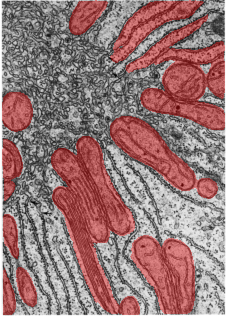

model_type argument is not used in v4.0.1+. Ignoring this argument...
pretrained model C:\Users\bridg\.cellpose\models\cpsam not found, using default model
pretrained model C:\Users\bridg\.cellpose\models\cpsam not found, using default model


No metrics produced for mitochondria

Segmenting feature: nuclei


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Found 10 objects (feature=nuclei)
Saved overlay to C:\Users\bridg\OneDrive\Documents\Coding_Projects\bio_stemgpt\bio_stemgpt\outputs\10788.tif_nuclei_overlay.png


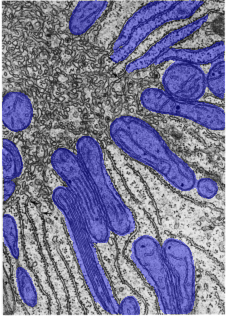

model_type argument is not used in v4.0.1+. Ignoring this argument...
pretrained model C:\Users\bridg\.cellpose\models\cpsam not found, using default model
pretrained model C:\Users\bridg\.cellpose\models\cpsam not found, using default model


No metrics produced for nuclei

Segmenting feature: membrane


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Found 11 objects (feature=membrane)
Saved overlay to C:\Users\bridg\OneDrive\Documents\Coding_Projects\bio_stemgpt\bio_stemgpt\outputs\10788.tif_membrane_overlay.png


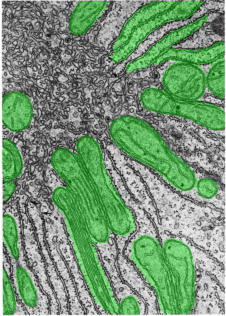

No metrics produced for membrane

Multi-feature demo complete. Outputs saved to C:\Users\bridg\OneDrive\Documents\Coding_Projects\bio_stemgpt\bio_stemgpt\outputs


In [33]:
# Demo: run segmentation for multiple features and save outputs
# Runs mitochondria, nuclei, and membrane segmentation on the first available image
# and writes overlays and per-feature metrics CSVs into ./outputs/

out_dir = Path('outputs')
out_dir.mkdir(exist_ok=True)

files = toolbox.list_files()
if not files:
    print('No .tif files found in data/ to run multi-feature demo. Add files and rerun this cell.')
else:
    name = files[0]
    print('Using image:', name)
    toolbox.load(name)

    for feature in ('mitochondria', 'nuclei', 'membrane'):
        print(f"\nSegmenting feature: {feature}")
        if feature == 'mitochondria':
            res = toolbox.segment(min_size=20, feature=feature)
        elif feature == 'nuclei':
            # nuclei are larger structures by default
            res = toolbox.segment(min_size=500, feature=feature)
        else:
            res = toolbox.segment(feature=feature)

        print(f"Found {res['count']} objects (feature={feature})")

        # save overlay PNG
        ov_path = out_dir / f"{name}_{feature}_overlay.png"
        with open(ov_path, 'wb') as fh:
            fh.write(res['overlay_png'])
        print('Saved overlay to', ov_path.resolve())

        # display in-notebook for quick check
        display(Image.open(io.BytesIO(res['overlay_png'])))

        # save metrics CSV if available
        m = toolbox.get_metrics()
        if m and m['rows']:
            csv_path = out_dir / f"{name}_{feature}_metrics.csv"
            toolbox.export_metrics(str(csv_path))
            print('Saved metrics to', csv_path.resolve())
            # show a preview
            display(pd.DataFrame(m['rows']).head())
        else:
            print('No metrics produced for', feature)

    print('\nMulti-feature demo complete. Outputs saved to', out_dir.resolve())

In [35]:
# Demo: Quick smoke runs
# This version supports a `quick_demo` flag for fast smoke tests (minimal I/O/display). Set `quick_demo=False` for the full demo.

In [40]:
def very_quick_count(img, feature='mitochondria', q_scale=0.20, use_gpu=False, diameter=None, use_cellpose=False):
    """Return an integer count of segmented objects using a very fast path.
    By default this uses the classical `skimage` pipeline which is very fast and
    avoids any heavy neural-network inference. Set `use_cellpose=True` to force
    a downsampled Cellpose quick run (may be much slower depending on model).
    """
    if use_cellpose and globals().get('HAVE_CELLPOSE'):
        # Use the fast count-only Cellpose path (downsampled quick-mode)
        res = segment_feature(img, feature=feature, method='cellpose', quick=True, q_scale=q_scale, skip_props=True, do_resize_back=False, use_gpu=use_gpu, diameter=diameter, count_only=True)
        return int(res.get('count', 0))
    else:
        # Super-fast classical skimage segmentation (default)
        res = segment_feature(img, feature=feature, method='skimage')
        return int(res.get('count', 0))

In [37]:
# Env check: verify Cellpose and torch availability in kernel
print('HAVE_CELLPOSE =', globals().get('HAVE_CELLPOSE'))
try:
    import torch
    print('torch:', torch.__version__)
except Exception as e:
    print('torch import error:', e)
try:
    import cellpose
    print('cellpose:', getattr(cellpose, '__version__', 'unknown'))
except Exception as e:
    print('cellpose import error:', e)

HAVE_CELLPOSE = True
torch: 2.9.1+cpu
cellpose: unknown


In [41]:
# Super-quick smoke check (skimage fallback, very fast)
from time import time
files = toolbox.list_files()
if not files:
    print('No .tif files found in data/ to run the super-quick smoke check.')
else:
    name = files[0]
    print('Testing image:', name)
    toolbox.load(name)
    img = toolbox.state['current_img']
    t0 = time()
    cnt = very_quick_count(img, feature='mitochondria', use_cellpose=False)
    t1 = time()
    print(f"Very quick count (skimage) for {name}: {cnt} objects (elapsed {t1-t0:.3f}s)")

Testing image: 10788.tif
Very quick count (skimage) for 10788.tif: 142 objects (elapsed 0.172s)


In [48]:
# Visualization demo: save plots to outputs and create comparative plots
print('Current image:', toolbox.state.get('current_path'))
# Ensure segmentation with metrics exists
seg_ok = (toolbox.state.get('last_segmentation') is not None and toolbox.state.get('metrics_df') is not None and not toolbox.state.get('metrics_df').empty)
if not seg_ok:
    print('No segmentation with metrics found. Running a fast skimage segmentation (metrics enabled) on the current image...')
    if toolbox.state.get('current_img') is None:
        files = toolbox.list_files()
        if not files:
            print('No images available in data/ to run the demo.')
        else:
            toolbox.load(files[0])
    toolbox.segment(method='skimage', skip_props=False)

# Plot and save Area vs Eccentricity
print('\nPlot 1: Area vs Eccentricity (current metrics)')
png = plot_area_vs_eccentricity(return_png=True)
if png:
    save_png(png, f"area_vs_eccentricity_{Path(toolbox.state['current_path']).name}.png")

# Plot and save centroid heatmap
print('\nPlot 2: Centroid heatmap (current metrics)')
png = plot_centroid_heatmap(return_png=True)
if png:
    save_png(png, f"centroid_heatmap_{Path(toolbox.state['current_path']).name}.png")

# Thumbnails
print('\nPlot 3: Example object thumbnails (current segmentation)')
png = display_object_thumbnails(n=9, return_png=True)
if png:
    save_png(png, f"thumbnails_{Path(toolbox.state['current_path']).name}.png")

# Counts across files and save CSV + PNG
print('\nPlot 4: Counts across all files (very quick skimage counts)')
df_counts, png = plot_counts_across_files(return_png=True)
print('\nCounts table (top rows):')
print(df_counts.head())
export_df_csv(df_counts, f"counts_{feature if 'feature' in globals() else 'mitochondria'}.csv")
if png:
    save_png(png, 'counts_across_files.png')

# Comparative example: compare top two images by count if available
if df_counts is not None and len(df_counts) >= 2:
    n1, n2 = df_counts['name'].iloc[0], df_counts['name'].iloc[1]
    print(f"\nComparing top two files: {n1} vs {n2}")
    res = compare_two_images(n1, n2, feature='mitochondria', min_size=20, save_filename=f"compare_{Path(n1).stem}_vs_{Path(n2).stem}.png")

print('\nSaved plots and CSVs to the ./outputs/ directory.')

Current image: data\10788.tif

Plot 1: Area vs Eccentricity (current metrics)
Saved plot to: C:\Users\bridg\OneDrive\Documents\Coding_Projects\bio_stemgpt\bio_stemgpt\outputs\area_vs_eccentricity_10788.tif.png

Plot 2: Centroid heatmap (current metrics)
Saved plot to: C:\Users\bridg\OneDrive\Documents\Coding_Projects\bio_stemgpt\bio_stemgpt\outputs\centroid_heatmap_10788.tif.png

Plot 3: Example object thumbnails (current segmentation)
Saved plot to: C:\Users\bridg\OneDrive\Documents\Coding_Projects\bio_stemgpt\bio_stemgpt\outputs\thumbnails_10788.tif.png

Plot 4: Counts across all files (very quick skimage counts)


C:\Users\bridg\AppData\Local\Temp\ipykernel_3804\1888623506.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df['name'].astype(str), rotation=45, ha='right')



Counts table (top rows):
        name  count
5   6518.tif    342
0  10788.tif    142
3  11458.tif    104
4   6516.tif     49
1  10790.tif     37
Saved CSV to: C:\Users\bridg\OneDrive\Documents\Coding_Projects\bio_stemgpt\bio_stemgpt\outputs\counts_membrane.csv
Saved plot to: C:\Users\bridg\OneDrive\Documents\Coding_Projects\bio_stemgpt\bio_stemgpt\outputs\counts_across_files.png

Comparing top two files: 6518.tif vs 10788.tif
Saved comparison figure to: C:\Users\bridg\OneDrive\Documents\Coding_Projects\bio_stemgpt\bio_stemgpt\outputs\compare_6518_vs_10788.png

Saved plots and CSVs to the ./outputs/ directory.


C:\Users\bridg\AppData\Local\Temp\ipykernel_3804\1888623506.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df['name'].astype(str), rotation=45, ha='right')


Comparing 6518.tif vs 10788.tif (feature=mitochondria)
Saved comparative summary to: C:\Users\bridg\OneDrive\Documents\Coding_Projects\bio_stemgpt\bio_stemgpt\outputs\compare_summary_6518_vs_10788.csv

Comparative summary:


,metric,n1,n2,mean1,mean2,median1,median2,sd1,sd2,ks_p,u_p,cohen_d,name1,name2,cohen_d_interpretation
0,area,500,220,1933.806000,3390.600000,89.000000,53.500000,18658.436876,44380.992505,8.230714e-06,8.005662e-08,-0.050183,6518.tif,10788.tif,negligible
1,eccentricity,500,220,0.825868,0.844325,0.864744,0.883666,0.133003,0.138763,6.653054e-03,8.343001e-03,-0.136939,6518.tif,10788.tif,negligible
2,solidity,500,220,0.760996,0.765778,0.777778,0.787762,0.125544,0.128001,4.945889e-01,4.549233e-01,-0.037858,6518.tif,10788.tif,negligible
3,mean_intensity,500,220,148.554932,158.362771,145.848821,158.972326,11.435271,9.729738,8.651815e-27,1.135942e-28,-0.896244,6518.tif,10788.tif,large


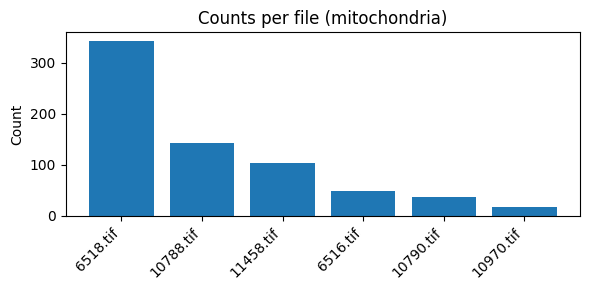

In [52]:
# Comparative summary demo: run comparison on top two files and save CSV
files = toolbox.list_files()
if len(files) < 2:
    print('Need at least two files in data/ to run comparative summary demo.')
else:
    # re-use the counts per file to pick top two by count
    df_counts = plot_counts_across_files(show=False)
    if df_counts is None or df_counts.empty:
        print('Counts are empty; aborting comparison demo')
    else:
        n1, n2 = df_counts['name'].iloc[0], df_counts['name'].iloc[1]
        print(f"Comparing {n1} vs {n2} (feature=mitochondria)")
        out = compare_two_images_summary(n1, n2, feature='mitochondria', min_size=20, save_csv=True)
        print('\nComparative summary:')
        display(out['summary'])

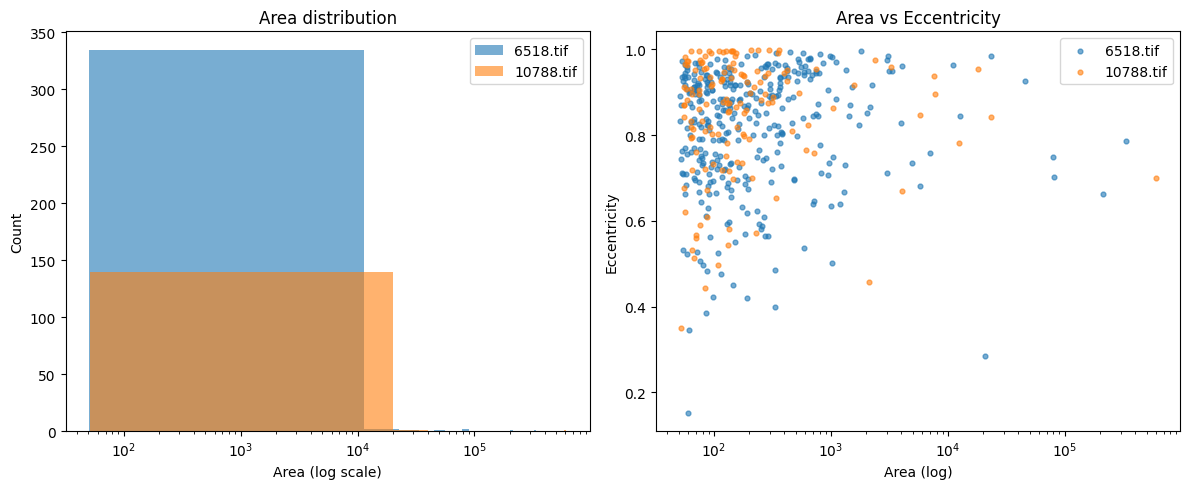

Failed to create violin for mean_intensity: name 'pvalue_to_stars' is not defined
Failed to create histogram for mean_intensity: name 'pvalue_to_stars' is not defined
Failed to create violin for area: name 'pvalue_to_stars' is not defined
Failed to create histogram for area: name 'pvalue_to_stars' is not defined
Saved plots:


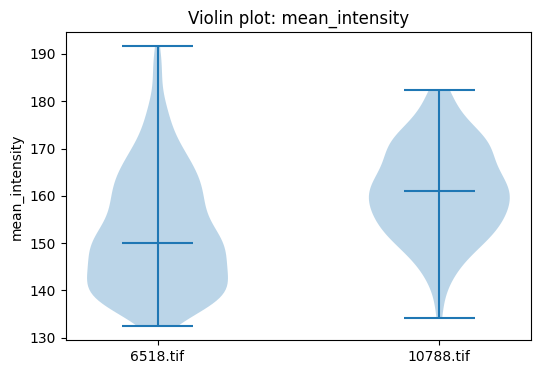

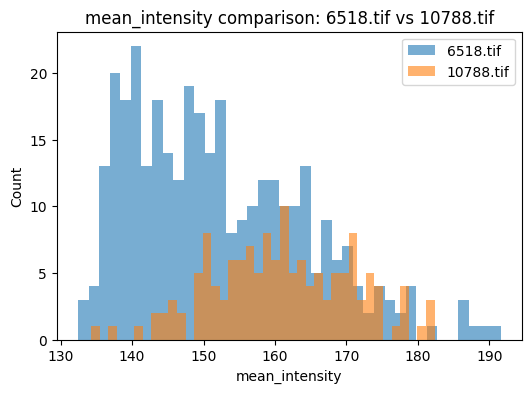

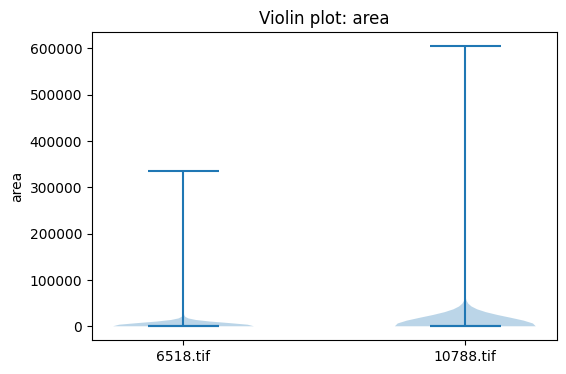

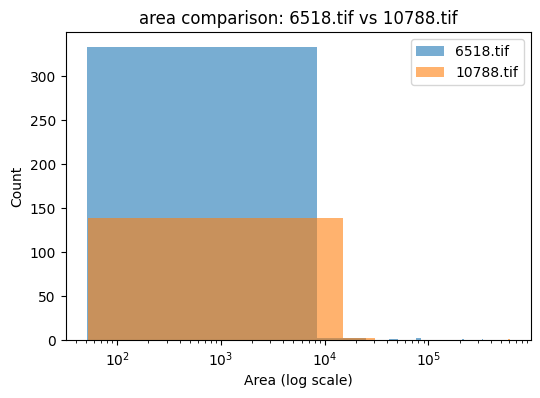

In [56]:
# Generate and save violin + histogram plots for mean_intensity and area comparing 6518.tif and 10788.tif
import os
os.makedirs('outputs', exist_ok=True)

res = compare_two_images('6518.tif','10788.tif', feature='mitochondria', min_size=50, return_png=False)
if res is None:
    raise RuntimeError('compare_two_images returned None')

df1 = res.get('df1')
df2 = res.get('df2')
if df1 is None or df2 is None:
    raise RuntimeError('Could not obtain df1/df2 from compare_two_images result')

labels = ['6518.tif','10788.tif']
saved = []
for metric in ['mean_intensity','area']:
    try:
        png = plot_violin_for_metric([df1,df2], labels=labels, metric=metric, return_png=True, show_stats=True)
        path_v = f"outputs/{metric}_violin_6518_vs_10788.png"
        with open(path_v,'wb') as f: f.write(png)
        saved.append(path_v)
    except Exception as e:
        print(f"Failed to create violin for {metric}: {e}")
    try:
        png2 = plot_histograms_metric_for_two_dfs(df1, df2, labels=labels, metric=metric, bins=40, return_png=True, show_stats=True)
        path_h = f"outputs/{metric}_hist_6518_vs_10788.png"
        with open(path_h,'wb') as f: f.write(png2)
        saved.append(path_h)
    except Exception as e:
        print(f"Failed to create histogram for {metric}: {e}")

print("Saved plots:")
for p in saved:
    print(p)

In [54]:
import inspect
for name in ['plot_violin_for_metric','plot_histograms_metric_for_two_dfs']:
    fn = globals().get(name)
    print(name, 'found' if fn is not None else 'NOT FOUND')
    if fn is not None:
        try:
            print('Signature:', inspect.signature(fn))
            from textwrap import dedent
            try:
                src = inspect.getsource(fn)
                print('\n'.join(src.splitlines()[:40]))
            except Exception as e:
                print('Could not get source:', e)
        except Exception as e:
            print('inspect failed:', e)
    print('-'*40)

plot_violin_for_metric found
Signature: (dfs, labels=None, metric='area', return_png=False)
def plot_violin_for_metric(dfs, labels=None, metric='area', return_png=False):
    """Violin plots for the same metric across multiple dataframes (list of dfs)."""
    if labels is None:
        labels = [f"{i}" for i in range(len(dfs))]
    data = [df[metric].dropna() for df in dfs]
    fig, ax = plt.subplots(figsize=(6,4))
    ax.violinplot(data, showmeans=False, showmedians=True)
    ax.set_xticks(np.arange(1, len(labels)+1))
    ax.set_xticklabels(labels)
    ax.set_ylabel(metric)
    ax.set_title(f'Violin plot: {metric}')
    plt.tight_layout()
    if return_png:
        buf = io.BytesIO(); plt.savefig(buf, format='png'); plt.close(); return buf.getvalue()
    display(fig)
    plt.close()
    return None
----------------------------------------
plot_histograms_metric_for_two_dfs found
Signature: (df1, df2, labels=('A', 'B'), metric='area', bins=30, return_png=False)
def plot_histograms_metr

In [55]:
def _cohen_d(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return np.nan
    sx = x.std(ddof=1)
    sy = y.std(ddof=1)
    pooled = np.sqrt(((nx-1)*sx*sx + (ny-1)*sy*sy) / (nx+ny-2))
    if pooled == 0:
        return np.nan
    return (x.mean() - y.mean()) / pooled


def plot_histograms_metric_for_two_dfs(df1, df2, labels=('A','B'), metric='area', bins=30, return_png=False, show_stats=True):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.hist(df1[metric].dropna(), bins=bins, alpha=0.6, label=labels[0])
    ax.hist(df2[metric].dropna(), bins=bins, alpha=0.6, label=labels[1])
    ax.set_xlabel(metric if metric!='area' else 'Area (log scale)')
    if metric == 'area':
        ax.set_xscale('log')
    ax.set_ylabel('Count')
    ax.legend()
    ax.set_title(f"{metric} comparison: {labels[0]} vs {labels[1]}")
    # stats
    if show_stats:
        try:
            ks_stat, ks_p = stats.ks_2samp(df1[metric].dropna(), df2[metric].dropna())
        except Exception:
            ks_p = np.nan
        try:
            u_stat, u_p = stats.mannwhitneyu(df1[metric].dropna(), df2[metric].dropna(), alternative='two-sided')
        except Exception:
            u_p = np.nan
        d = _cohen_d(df1[metric].dropna(), df2[metric].dropna())
        txt = f"KS p={ks_p:.3g} {pvalue_to_stars(ks_p)}\nMWU p={u_p:.3g} {pvalue_to_stars(u_p)}\nCohen d={d:.2f}"
        annotate_ax_with_stats(ax, txt)
    plt.tight_layout()
    if return_png:
        buf = io.BytesIO(); plt.savefig(buf, format='png'); plt.close(); return buf.getvalue()
    display(fig)
    plt.close()
    return None


def plot_violin_for_metric(dfs, labels=None, metric='area', return_png=False, show_stats=True):
    if labels is None:
        labels = [f"{i}" for i in range(len(dfs))]
    data = [df[metric].dropna() for df in dfs]
    fig, ax = plt.subplots(figsize=(6,4))
    parts = ax.violinplot(data, showmeans=False, showmedians=True)
    ax.set_xticks(np.arange(1, len(labels)+1))
    ax.set_xticklabels(labels)
    ax.set_ylabel(metric)
    ax.set_title(f'Violin plot: {metric}')
    # stats: if two groups, run Mann-Whitney U and annotate
    if show_stats and len(dfs) == 2:
        try:
            u_stat, u_p = stats.mannwhitneyu(data[0], data[1], alternative='two-sided')
        except Exception:
            u_p = np.nan
        d = _cohen_d(data[0], data[1])
        txt = f"MWU p={u_p:.3g} {pvalue_to_stars(u_p)}\nCohen d={d:.2f}"
        annotate_ax_with_stats(ax, txt)
    elif show_stats and len(dfs) > 2:
        try:
            kw_stat, kw_p = stats.kruskal(*data)
        except Exception:
            kw_p = np.nan
        txt = f"Kruskal-Wallis p={kw_p:.3g} {pvalue_to_stars(kw_p)}"
        annotate_ax_with_stats(ax, txt)
    plt.tight_layout()
    if return_png:
        buf = io.BytesIO(); plt.savefig(buf, format='png'); plt.close(); return buf.getvalue()
    display(fig)
    plt.close()
    return None